In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam,SGD

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
gen=ImageDataGenerator(rotation_range=30, width_shift_range=0.3,
                      shear_range=0.4, rescale=1./255)

In [3]:
data_path = './data/cnd/'
batch_size = 9892

In [4]:
data_gen = gen.flow_from_directory(directory=data_path,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  target_size=(128,128),
                                  class_mode='categorical')
img, label = data_gen.next()

Found 9892 images belonging to 2 classes.


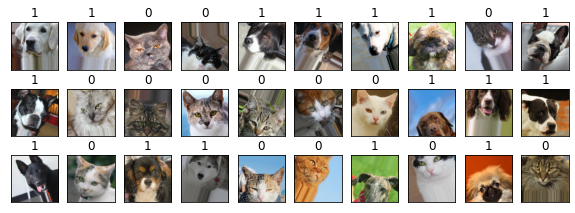

In [5]:
plt.figure(figsize=(10,12))
for i in range(30):
    plt.subplot(10,10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(str(np.argmax(label[i])))
    plt.imshow(img[i])

In [6]:
result = []
for i in range(9892):
    result.append(np.argmax(label[i]))
result = np.array(result).reshape(-1, 1)
result.shape

(9892, 1)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
x_train, x_test, y_train, y_test = train_test_split(img, result,test_size=0.3,
shuffle=False, random_state=1004)

In [9]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (6924, 128, 128, 3)
x_test shape: (2968, 128, 128, 3)
y_train shape: (6924, 1)
y_test shape: (2968, 1)


In [10]:
y_train[0:10]

array([[1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1]], dtype=int64)

In [11]:
#(One_Hot encoding): 여러개 중 하나만 핫하게 만든다?
y_train=tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test=tf.keras.utils.to_categorical(y_test, num_classes=2)

In [12]:
print(y_train[0]) #2
print(y_test[0]) #0

[0. 1.]
[0. 1.]


In [13]:
#모델구축
cnn=Sequential()
cnn.add(Conv2D(32, (3,3), padding='same',activation='relu', input_shape=(128,128,3)))
cnn.add(Conv2D(kernel_size=(3,3), filters=32, padding='same',activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))
# 단 쌓기 단쌓으면 이미지가 줄어서 줄지 않도록 만들기 (패딩넣기)
# 단 쌓아서 정확도가 올라갔다.
cnn.add(Conv2D(kernel_size=(3,3), filters=64, padding='same', activation='relu'))
cnn.add(Conv2D(kernel_size=(3,3), filters=64, padding='same', activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2)))
cnn.add(Dropout(0.3))

cnn.add(Conv2D(kernel_size=(3,3), filters=128, padding='same', activation='relu'))
cnn.add(Conv2D(kernel_size=(3,3), filters=128, padding='same', activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(kernel_size=(3,3), filters=256, padding='same', activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

# 완전연결성 평탄화
cnn.add(Flatten())

cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5))
#출력 2 (2가지중에 하나)
cnn.add(Dense(2, activation='softmax'))

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                        

In [14]:
from datetime import datetime

start_time = datetime.now()

cnn.compile(loss='categorical_crossentropy', optimizer=Adam(),metrics=['accuracy'])

#손실함수가 5 epochs을 진행을 검사하여 더 이상 줄어들이 않으면 종료
#EarlyStopping(모니터링 값. 대기 epochs)

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
early_stoping=EarlyStopping(monitor='val_loss', patience=10)
#학습중인 모델을 자동 저장
model_checkpoint=ModelCheckpoint(filepath="./data/test.h5",
                                 monitor='val_loss',
                                 save_base_only=True,
                                 verbose=1)
hist = cnn.fit(x_train, y_train, batch_size=128, epochs=250, validation_data=(x_test, y_test),callbacks=[early_stoping,model_checkpoint])

end_time =datetime.now()
print('경과시간= ',end_time-start_time)

Epoch 1/250
55/55 [==============================] - ETA: 0s - loss: 0.6951 - accuracy: 0.5111
Epoch 1: saving model to ./data\test.h5
55/55 [==============================] - 236s 4s/step - loss: 0.6951 - accuracy: 0.5111 - val_loss: 0.6922 - val_accuracy: 0.5270
Epoch 2/250
55/55 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5183
Epoch 2: saving model to ./data\test.h5
55/55 [==============================] - 228s 4s/step - loss: 0.6927 - accuracy: 0.5183 - val_loss: 0.6922 - val_accuracy: 0.5270
Epoch 3/250
55/55 [==============================] - ETA: 0s - loss: 0.6914 - accuracy: 0.5212
Epoch 3: saving model to ./data\test.h5
55/55 [==============================] - 226s 4s/step - loss: 0.6914 - accuracy: 0.5212 - val_loss: 0.6893 - val_accuracy: 0.5283
Epoch 4/250
55/55 [==============================] - ETA: 0s - loss: 0.6767 - accuracy: 0.5773
Epoch 4: saving model to ./data\test.h5
55/55 [==============================] - 225s 4s/step - loss: 0.6767 -

In [15]:
cnn.evaluate(x_test, y_test)

93/93 [==============================] - 14s 147ms/step - loss: 0.1075 - accuracy: 0.9734


[0.10753986984491348, 0.9733827710151672]

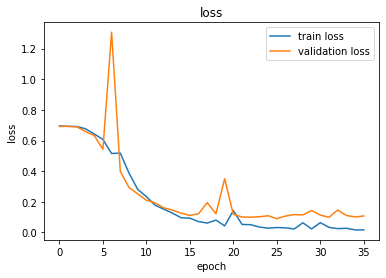

In [16]:
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(hist.history['loss'],label='train loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.legend(loc='best')
plt.show()

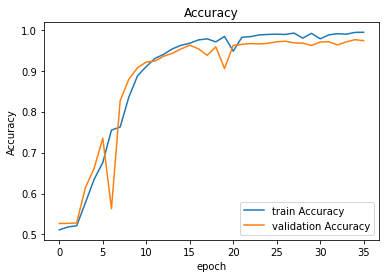

In [17]:
# loss대신 정확도
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.plot(hist.history['accuracy'],label='train Accuracy')
plt.plot(hist.history['val_accuracy'], label='validation Accuracy')
plt.legend(loc='best')
plt.show()

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#원핫에 중복되는 코드
map = ['cat','dog']
predicted_value = cnn.predict(x_test)

print(y_test.dtype)
print(predicted_value.dtype)

93/93 [==============================] - 17s 185ms/step
float32
float32


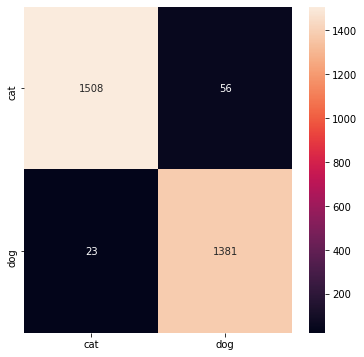

In [19]:
plt.figure(figsize=(6, 6))
cm = confusion_matrix(np.argmax(y_test, axis=-1),
                       np.argmax(predicted_value, axis=-1))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=map, yticklabels=map)
plt.show()

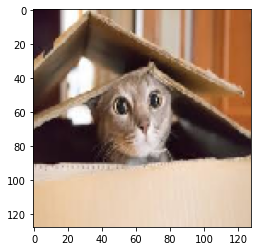

In [20]:
img_path = "./data/cat1.jpg"
img = load_img(img_path, target_size=(128, 128))
plt.imshow(img)
plt.show()

In [21]:
img_array = img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

print(f"이 사람은 {map[np.argmax(cnn.predict(img_batch))]} 다.")

1/1 [==============================] - 0s 50ms/step
이 사람은 cat 다.


In [22]:
from tensorflow import keras
mod_path = './data/test.h5'
keras_mod = tf.keras.models.load_model(mod_path)
converter = tf.lite.TFLiteConverter.from_keras_model(keras_mod)
tflite_model = converter.convert()
with tf.io.gfile.GFile('./data/model2.aflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmpxzpl9tqd\assets


INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmpxzpl9tqd\assets
